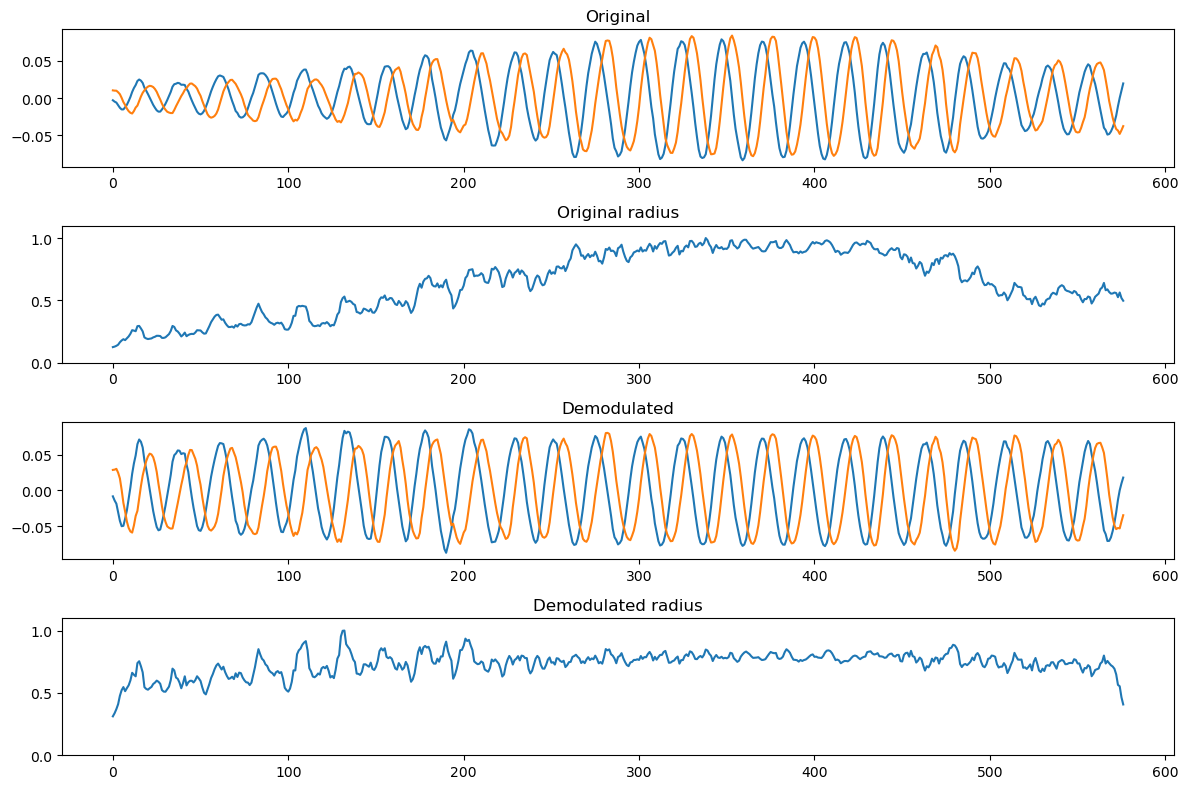

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def autocorr(x):
    """
    Fast autocorrelation based on the Wiener-Khinchin Theorem, which allows us
    to use the fast fourier transform of the input to compute the autocorrelation
    Parameters
    ----------
    x: ndarray(N)
        Array on which to compute the autocorrelation
    
    Returns
    -------
    ndarray(N): The autocorrelation
    """
    N = len(x)
    xpad = np.zeros(N*2)
    xpad[0:N] = x
    F = np.fft.fft(xpad)
    FConv = np.real(F)**2 + np.imag(F)**2 # Fourier transform of the convolution of x and its reverse
    return np.real(np.fft.ifft(FConv)[0:N])

def demodulate(v1, v2, bias=0.1, order=11):
    """
    Estimate a signal's envelope by finding the fundamental frequency,
    moving it to baseband, lowpass filtering it, and then using that
    as the envelope.
    Divide the original signal by this envelope plus a bias to avoid
    dividing by 0
    
    Parameters
    ----------
    v1: ndarray(N)
        First eigenvector
    v2: ndarray(N)
        Second eigenvector
    bias: float
        Add this to the envelope before dividing (this is a bit of a hack, but 
        it seems to work)
    order: int
        Order of FIR lowpass filter
    """
    from scipy import signal
    # Estimate period
    a = autocorr(v1)
    T = 10+np.argmax(a[10::])
    
    # Bring modulation back to "baseband" and filter out
    # with a lowpass filter
    demod = np.cos(2*np.pi*np.arange(v1.size)/T)
    cutoff = T/v1.size
    bands = (0, cutoff, cutoff, 0.5)
    desired = (1, 1, 0, 0)
    b = signal.firls(order, bands, desired, nyq=0.5)
    a = [1]
    w, h = signal.freqz(b)
    mod1 = signal.filtfilt(b, a, v1*demod)
    mod2 = signal.filtfilt(b, a, v2*demod)
    
    # Divide by the estimated modulation
    r = np.sqrt(mod1**2+mod2**2)
    r = bias + r/np.max(r) # This "bias" is a bit of a hack, but it seems to work
    v1filt = v1/r
    v2filt = v2/r
    return v1filt, v2filt
    

res = np.load("AT1G58602.1.npy") # Modulated, but good the whole time
#res = np.load("AT1G63730.1.npy") # Hairpin in beginning
#res = np.load("AT4G27190.1.npy") # Two hairpins in middle

v1 = res[:, 0]
v2 = res[:, 1]
v1filt, v2filt = demodulate(v1, v2)

r = np.sqrt(v1**2+v2**2)
r = r/np.max(r)
rfilt = np.sqrt(v1filt**2+v2filt**2)
rfilt = rfilt/np.max(rfilt)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(v1)
plt.plot(v2)
plt.title("Original")
plt.subplot(412)
plt.plot(r)
plt.ylim([0, 1.1])
plt.title("Original radius")
plt.subplot(413)
plt.plot(v1filt)
plt.plot(v2filt)
plt.title("Demodulated")
plt.subplot(414)
plt.plot(rfilt)
plt.ylim([0, 1.1])
plt.title("Demodulated radius")
plt.tight_layout()